In [8]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.special import erf

sys.path.insert(0, os.path.join("..", "..", "..", "estimators"))

from entropy_estimators import mi

plt.rc("text", usetex=True)

In [9]:
n_list = [200, 500, 1_000, 2_000]
n_iter = 2_000

rho = 0.8
mu = np.zeros(2)
sigma = np.array([[1, rho], [rho, 1]])

In [10]:
def gauss_cdf(x, mu, sigma):
    return 0.5 * (1 + erf((x-mu)/(np.sqrt(2)*sigma)))

def uniform_reparam(x, mus=0., sigmas=1.):
    if isinstance(mus, (int, float)):
        mus = [mus] * x.shape[1]
    if isinstance(sigmas, (int, float)):
        sigmas = [sigmas] * x.shape[1]
    
    y = x.copy()
    for k in range(y.shape[1]):
        y[:, k] = gauss_cdf(y[:, k], mus[k], sigmas[k])
    
    return y

def exp_invcdf(u, lamda):
    # CDF: u = 1 - np.exp(-lamda*x)
    return - np.log(1-u) / lamda

In [11]:
distrib_dict = {
    "normal": lambda sz: np.random.multivariate_normal(mu, sigma, size=sz),
    "uniform": lambda sz: uniform_reparam(np.random.multivariate_normal(mu, sigma, size=sz)),
    "exponential": lambda sz: exp_invcdf(
        uniform_reparam(np.random.multivariate_normal(mu, sigma, size=sz)), 1
    ),
}

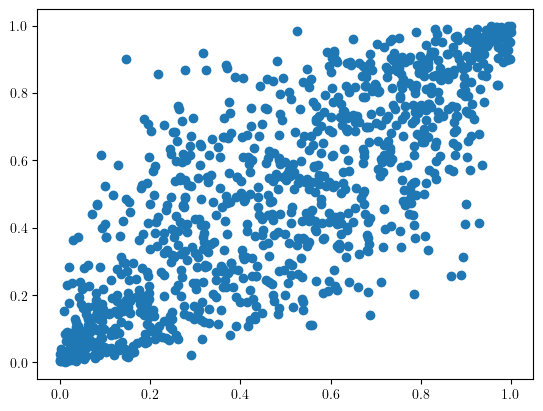

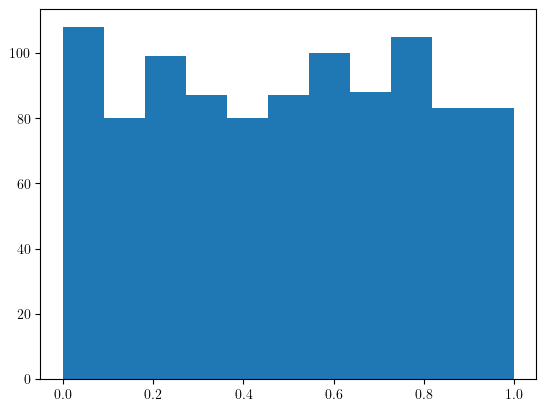

In [12]:
x = distrib_dict["uniform"](1_000)
np.corrcoef(x.T)

plt.scatter(x[:, 0], x[:, 1])
plt.show()

plt.hist(x[:, 0], bins="auto")
plt.show()

In [13]:
vars_dict = {dist: [] for dist in distrib_dict}
for dist in vars_dict:
    print(dist)
    for n in n_list:

        mis = []
        for _ in tqdm(range(n_iter)):
        
            data = distrib_dict[dist](n)
            mis.append(
                mi(data[:, 0], data[:, 1])
            )

            # if _ == 0:
            #     plt.hist(data[:, 0], bins="auto")
            #     plt.show()

        vars_dict[dist].append(np.var(mis))
    print()

normal


100%|██████████| 2000/2000 [00:15<00:00, 130.41it/s]



uniform


100%|██████████| 2000/2000 [00:14<00:00, 137.96it/s]



exponential


100%|██████████| 2000/2000 [00:14<00:00, 135.66it/s]

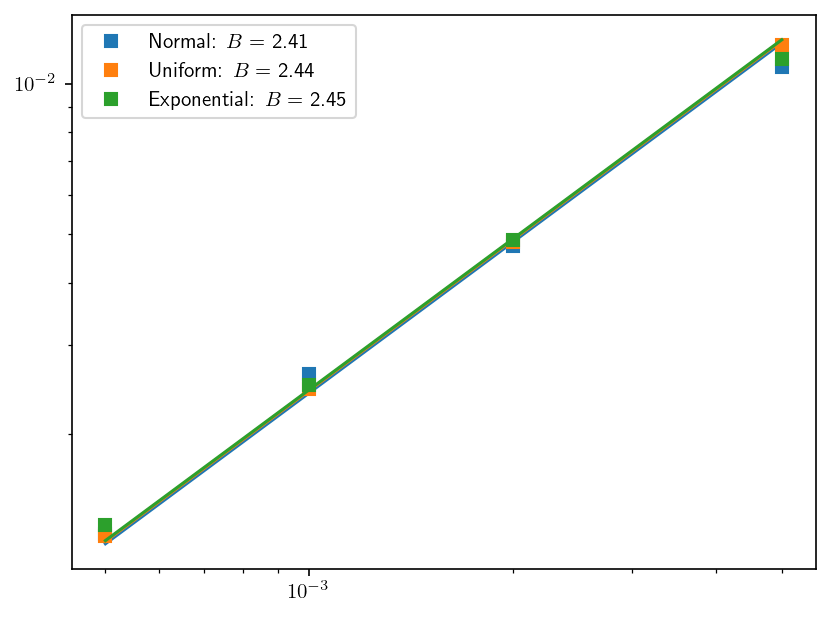

In [19]:
plt.figure(dpi=150)

for dist, vars in vars_dict.items():
    Nis, sigma2s = np.array(n_list), np.array(vars)
    B = np.mean(np.log(sigma2s) - np.log(1/Nis))
    B = np.exp(B)

    lines = plt.loglog(1/Nis, vars, linestyle="none", marker="s", label=f"{dist.capitalize()}: $B=$ {B:.2f}")

    linecolor = lines[0].get_color()
    plt.loglog(1/Nis, B/Nis, color=linecolor)

plt.legend(loc="upper left")
plt.show()

In [58]:
from sklearn.datasets import make_blobs

_, __, centers = make_blobs(n_samples=n, centers=10, n_features=2, random_state=0, return_centers=True)

In [59]:
memory_vars = []
for n in n_list:

    memory_mis = []
    for k in tqdm(range(n_iter)):
        X, y = make_blobs(n_samples=n, centers=centers, n_features=2)

        memory_mis.append(
            mi(X[:, 0], X[:, 1])
        )

    memory_vars.append(np.var(memory_mis))

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:12<00:00, 158.54it/s]


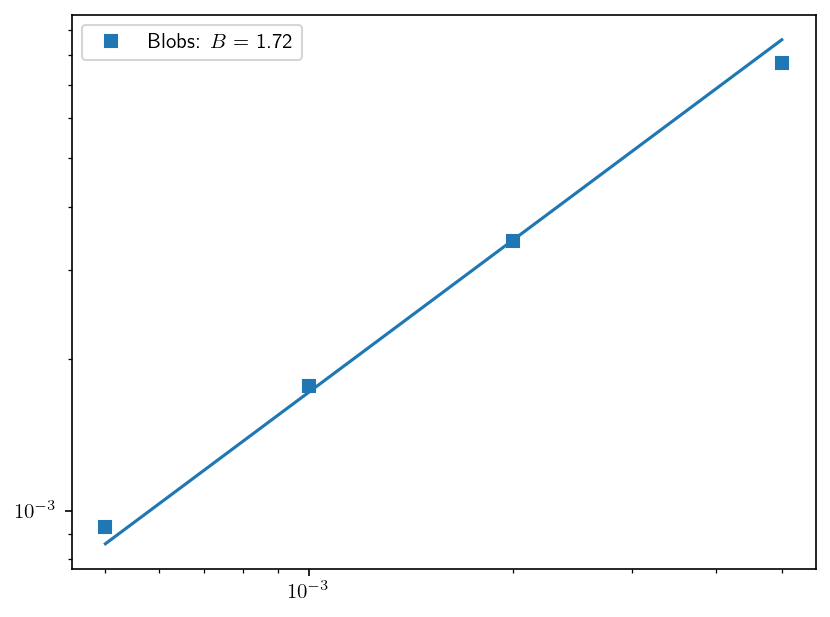

In [60]:
Nis, sigma2s = np.array(n_list), np.array(memory_vars)
B = np.mean(np.log(sigma2s) - np.log(1/Nis))
B = np.exp(B)

plt.figure(dpi=150)

lines = plt.loglog(1/Nis, sigma2s, linestyle="none", marker="s", label=f"Blobs: $B=$ {B:.2f}")

linecolor = lines[0].get_color()
plt.loglog(1/Nis, B/Nis, color=linecolor)

plt.legend()
plt.show()